In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/DeepMatrix/parallel_light_glue

/content/drive/MyDrive/DeepMatrix/parallel_light_glue


In [7]:
!pip install utm


  Preparing metadata (setup.py) ... done
  Created wheel for utm: filename=utm-0.8.0-py3-none-any.whl size=8536 sha256=4a692b41bab122ff080f2e21b3dd15c57d89f68dd980aa0ebd33fff236f4f8eb
  Stored in directory: /root/.cache/pip/wheels/b0/88/9b/1968d3a5933864f7d6312d8217027dd4d52b9647f678c67023
Successfully built utm


In [9]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [10]:
import sys
sys.path.append('/content/drive/MyDrive/DeepMatrix/parallel_light_glue')
import utils

In [18]:
import torch
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0)) # Changed to get_device_name
else:
    print("GPU Name: No GPU")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA Available: True
GPU Name: Tesla T4


In [19]:
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from utils import remove_dim, save_output_temp, change_device, read_feature, ImageDataset, get_matches
from assets.lightglue import LightGlue
from assets.superpoint import SuperPoint

In [20]:
def load_dataset(response_path):
    return ImageDataset(response_path)

# Store features in RAM instead of saving to disk
feature_cache = {}

def extract_features(index, dataset, extractor):
    image_tensor = dataset[index].to(device)  # Move input to the correct device
    with torch.no_grad():
        feature_cache[index] = extractor.extract(image_tensor)  # Store features in memory


In [21]:
def compute_similarity(pair):
    idx, jdx = pair
    feat0 = feature_cache[idx]  # Access cached features
    feat1 = feature_cache[jdx]

    matcher = LightGlue(features="superpoint").eval().to(device)

    with torch.no_grad():
        matches01 = matcher({"image0": feat0, "image1": feat1})

    output = remove_dim([feat0, feat1, matches01])
    output = [change_device(t, 'cpu') for t in output]  # Move to CPU before returning
    return (idx, jdx, get_matches(output, True))




In [22]:
def run(response_path, output_path):
    dataset = load_dataset(response_path)

    max_keypoints = 1024 if torch.cuda.is_available() else 256
    extractor = SuperPoint(max_num_keypoints=max_keypoints).eval().to(device)

    print("Extracting Features...")
    feature_cache.clear()  # Clear any previous cache

    for idx in tqdm(range(len(dataset)), desc="Feature Extraction"):
        extract_features(idx, dataset, extractor)  # Extract and store features in RAM

    pairs = [(idx, jdx) for idx in range(len(dataset)) for jdx in range(idx + 1, len(dataset))]

    print("Computing Similarities...")

    # Since multiprocessing does not work well with GPU tensors, run sequentially
    results = []
    for pair in tqdm(pairs, desc="Computing Similarities"):
        results.append(compute_similarity(pair))

    save_dict = {f"({dataset.image_paths[idx]}, {dataset.image_paths[jdx]})": score for idx, jdx, score in results}

    with open(os.path.join(output_path, "output.json"), 'w') as f:
        json.dump(save_dict, f)

    print("Processing complete. Results saved.")


In [23]:
response_path = "/content/drive/MyDrive/DeepMatrix/parallel_light_glue/dataset/response_path"
output_path = "/content/drive/MyDrive/DeepMatrix/parallel_light_glue/output_path"
run(response_path, output_path)


Extracting Features...


Feature Extraction: 100%|██████████| 50/50 [01:43<00:00,  2.08s/it]


Computing Similarities...


Computing Similarities:   0%|          | 0/1225 [00:00<?, ?it/s]Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth

  0%|          | 0.00/45.3M [00:00<?, ?B/s]
 22%|██▏       | 10.1M/45.3M [00:00<00:00, 90.5MB/s]
 63%|██████▎   | 28.8M/45.3M [00:00<00:00, 148MB/s] 
100%|██████████| 45.3M/45.3M [00:00<00:00, 132MB/s]
Computing Similarities: 100%|██████████| 1225/1225 [04:30<00:00,  4.53it/s]


Processing complete. Results saved.


Total Comparisons: 67894
Min Score: 0.10000043362379074
Max Score: 0.9999681115150452
Mean Score: 0.5557101748883285


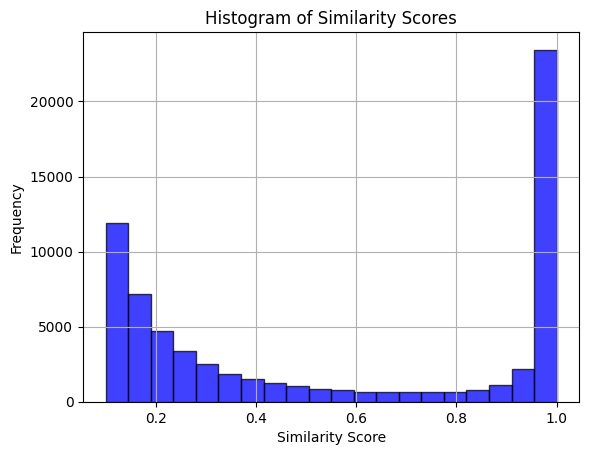

In [24]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load JSON file
with open("/content/drive/MyDrive/DeepMatrix/parallel_light_glue/output_path/output.json", "r") as f:
    data = json.load(f)

# Extract similarity scores
scores = []
for key, matches in data.items():
    if isinstance(matches, list):
        for match in matches:
            if isinstance(match, list) and len(match) == 3:
                scores.append(match[2])  # Extract similarity score

if not scores:
    print("No valid similarity scores found!")
    exit()

# Print statistics
print(f"Total Comparisons: {len(scores)}")
print(f"Min Score: {min(scores)}")
print(f"Max Score: {max(scores)}")
print(f"Mean Score: {np.mean(scores)}")

# Plot histogram
plt.hist(scores, bins=20, color='blue', edgecolor='black', alpha=0.75)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Histogram of Similarity Scores')
plt.grid(True)
plt.show()

In [25]:
from google.colab import files
files.download('/content/drive/MyDrive/DeepMatrix/parallel_light_glue/output_path/output.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>